# Santa Monica Airbnb Data Analysis
This is a notebook that contains an analysis of Airbnb data for LA that were compiled on Nov. 3, 2020, from http://insideairbnb.com/get-the-data.html
The focus of this analysis is on the city of Santa Monica, where my husband and I live and host Airbnb ourselves. We are particularly interested in price/availability/amenities information in this area, and how price/availability are related to different features of the properties.  
I will use the CRISP-DM process to outline this project.

## Business Understanding
We would like to find ways (add more amenities, renovate our property, etc.) to improve our booking rate and (hopefully also) the price. In order to achieve this goal, the three questions I would like to ask in this analysis are:  
(1) How the price/availability relate to the room type and bath type?  
(2) What are the popular amenities offered by the hosts in Santa Monica?  
(3) What are the most influential features to estimate the price/availability of a listing?

## Data Understanding

First, import the needed libraries and data

In [108]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import seaborn as sns
from collections import defaultdict, Counter
from sklearn.feature_selection import SelectKBest, f_regression
import math
%matplotlib inline

In [109]:
df = pd.read_csv('listings.csv')
df.head()

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,109,https://www.airbnb.com/rooms/109,20201009145904,2020-10-25,Amazing bright elegant condo park front *UPGRA...,"*** Unit upgraded with new bamboo flooring, br...",NaN,https://a0.muscache.com/pictures/4321499/1da98...,521,https://www.airbnb.com/users/show/521,...,8.0,10.0,8.0,NaN,f,1,1,0,0,0.02
1,2708,https://www.airbnb.com/rooms/2708,20201009145904,2020-10-10,Beautiful Furnish Mirrored Mini-Suite w/ Firep...,Beautiful Furnished Mirror Mini-Suite w/ Firep...,We are minutes away from the Mentor Language I...,https://a0.muscache.com/pictures/miso/Hosting-...,3008,https://www.airbnb.com/users/show/3008,...,10.0,10.0,10.0,NaN,t,2,0,2,0,0.35
2,2732,https://www.airbnb.com/rooms/2732,20201009145904,2020-10-18,Zen Life at the Beach,An oasis of tranquility awaits you.<br /><br /...,"This is the best part of Santa Monica. Quiet, ...",https://a0.muscache.com/pictures/1082974/0f74c...,3041,https://www.airbnb.com/users/show/3041,...,9.0,10.0,9.0,228269,f,2,1,1,0,0.18
3,2864,https://www.airbnb.com/rooms/2864,20201009145904,2020-10-10,* Beautiful Master Suite/Jacuzzi Tub/*,Centrally located.... Furnished with King Size...,What makes the neighborhood unique is that the...,https://a0.muscache.com/pictures/23817858/de20...,3207,https://www.airbnb.com/users/show/3207,...,NaN,NaN,NaN,NaN,t,1,1,0,0,NaN
4,5729,https://www.airbnb.com/rooms/5729,20201009145904,2020-10-25,Zen Room with Floating Bed near Venice and LAX,Our home is located near Venice Beach without ...,Our neighborhood is very quiet and save. There...,https://a0.muscache.com/pictures/f48e3ea8-2075...,9171,https://www.airbnb.com/users/show/9171,...,10.0,10.0,9.0,NaN,f,4,1,3,0,1.69


In [110]:
df.shape

(30533, 74)

So there are 30533 listings in LA in Nov, 2020, and there are 74 features. Let's take a look at the data type of these features.

In [111]:
df.dtypes.value_counts()

object     35
float64    22
int64      17
dtype: int64

Let's take a look at each data type. First, what columns contain "object" type?

In [112]:
# find the name of the columns which are objects data type
df.select_dtypes('O').columns

Index(['listing_url', 'last_scraped', 'name', 'description',
       'neighborhood_overview', 'picture_url', 'host_url', 'host_name',
       'host_since', 'host_location', 'host_about', 'host_response_time',
       'host_response_rate', 'host_acceptance_rate', 'host_is_superhost',
       'host_thumbnail_url', 'host_picture_url', 'host_neighbourhood',
       'host_verifications', 'host_has_profile_pic', 'host_identity_verified',
       'neighbourhood', 'neighbourhood_cleansed',
       'neighbourhood_group_cleansed', 'property_type', 'room_type',
       'bathrooms_text', 'amenities', 'price', 'has_availability',
       'calendar_last_scraped', 'first_review', 'last_review', 'license',
       'instant_bookable'],
      dtype='object')

It's worthy noticing that "price" contains "object" type because it contains "$" and ",". We need to convert the value of price into float data type later for further analysis.
What columns contain "float" or "int" type?

In [113]:
# find the name of the columns which are float64 data type
df.select_dtypes('float64').columns

Index(['host_listings_count', 'host_total_listings_count', 'latitude',
       'longitude', 'bathrooms', 'bedrooms', 'beds', 'minimum_minimum_nights',
       'maximum_minimum_nights', 'minimum_maximum_nights',
       'maximum_maximum_nights', 'minimum_nights_avg_ntm',
       'maximum_nights_avg_ntm', 'calendar_updated', 'review_scores_rating',
       'review_scores_accuracy', 'review_scores_cleanliness',
       'review_scores_checkin', 'review_scores_communication',
       'review_scores_location', 'review_scores_value', 'reviews_per_month'],
      dtype='object')

In [114]:
# find the name of the columns which are int64 data type
df.select_dtypes('int64').columns

Index(['id', 'scrape_id', 'host_id', 'accommodates', 'minimum_nights',
       'maximum_nights', 'availability_30', 'availability_60',
       'availability_90', 'availability_365', 'number_of_reviews',
       'number_of_reviews_ltm', 'number_of_reviews_l30d',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms',
       'calculated_host_listings_count_shared_rooms'],
      dtype='object')

## Data Preparation

As mentioned, I want to focus on "Santa Monica" neighborhood. Thus in the following, I will select data from this particular neighborhood and name this new dataframe as "SantaM".

In [115]:
SantaM = df[df.neighbourhood_cleansed=='Santa Monica']
# make the index start with 0 for the new dataframe
SantaM.index=range(len(SantaM))
SantaM.shape

(1116, 74)

So there are 1116 listings in Santa Monica in Nov. 2020. Then let's see among these listings, how many values are missing for each feature.

In [116]:
pd.set_option('display.max_rows', 74)
SantaM.isnull().sum().sort_values(ascending=False)

bathrooms                                       1116
calendar_updated                                1116
license                                          571
neighborhood_overview                            431
neighbourhood                                    431
host_about                                       348
review_scores_location                           272
review_scores_checkin                            272
review_scores_communication                      272
review_scores_value                              272
review_scores_cleanliness                        271
review_scores_accuracy                           271
review_scores_rating                             268
last_review                                      263
first_review                                     263
reviews_per_month                                263
host_response_rate                               163
host_response_time                               163
host_acceptance_rate                          

We can drop "bathrooms" and "calendar_updated" columns, as all data points are missing. 

In [117]:
SantaM.drop(columns = ['bathrooms','calendar_updated'], inplace=True)

/Users/zhaoli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [118]:
SantaM.shape

(1116, 72)

It's good to find that most of the features to be considered in this analysis have zero or very few missing values. I noticed that there are two rows miss "bathroom_type" value, let's take a look at them:

In [119]:
SantaM[SantaM.bathrooms_text.isnull()==True]

,id,listing_url,scrape_id,last_scraped,name,description,neighborhood_overview,picture_url,host_id,host_url,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
33,849943,https://www.airbnb.com/rooms/849943,20201009145904,2020-10-25,Private Room Montana Ave Best of SM,<b>The space</b><br />Please do not book witho...,NaN,https://a0.muscache.com/pictures/d68e3173-b704...,4437933,https://www.airbnb.com/users/show/4437933,...,10.0,10.0,10.0,NaN,f,2,0,2,0,0.03
863,42279288,https://www.airbnb.com/rooms/42279288,20201009145904,2020-10-25,Hotel Shangri-La,NaN,NaN,https://a0.muscache.com/pictures/89b1c0aa-a6d4...,271081037,https://www.airbnb.com/users/show/271081037,...,NaN,NaN,NaN,NaN,f,4,0,0,0,NaN


In [120]:
SantaM[SantaM.bathrooms_text.isnull()==True].price

33     $69.00
863     $0.00
Name: price, dtype: object

It seems that Row 863 is incorrect -- the price is "0" per night (I checked the URL of this listing and it's clearly not "0" dollar. Because I know this info is incorrect, I decide to drop this row as well. 

In [121]:
SantaM.drop(index = 863, inplace=True)
SantaM.index=range(len(SantaM))

/Users/zhaoli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [124]:
SantaM.shape

(1115, 72)

From previous lines, we know that both "availability_30" and "price" features have no missing values (great).
One thing before we do further analysis is that "price" feature is an "object" type, instead of a "float" type, so we need to convert it first.

In [125]:
SantaM.price = SantaM.price.str.replace('$', '')
SantaM.price = SantaM.price.str.replace(',', '')
SantaM.price = SantaM.price.astype('float')

/Users/zhaoli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/generic.py:5303: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


## Data Modeling

### Question 1
How the price/availability relate to the room type and bath type?  

In [126]:
SantaM.room_type.value_counts().sort_values(ascending=False)

Entire home/apt    833
Private room       268
Shared room          9
Hotel room           5
Name: room_type, dtype: int64

The majority of listings in Santa Monica in Nov. 2020 are either entire home/apt or private roomm. There are only 9 listings of shared room and 6 listings of hotel room, maybe because of pandemic. What does the availability of each room type look like?

In [127]:
SantaM.groupby(['room_type'])['availability_30'].mean().sort_values(ascending=False)

room_type
Hotel room         24.800000
Private room       13.074627
Shared room        11.333333
Entire home/apt    10.369748
Name: availability_30, dtype: float64

Because we will use bar chart repeatly, let's first define a function for data visualization.

In [128]:
def plot_bar(df, group_by, feature, ascending=False):
    """
    Plot a bar chart to visualize a certain feature of different groups (room types, bathrooms, etc.) 
    
    Parameters:
    df: Dataframe to be used
    group_by: the column based on which the current analysis is group by
    feature: the feature column that we focus on in this plot
    ascending: depending on the need, we can show the result in the ascending or descending order (default is descending)
    
    Returns:
    a bar plot that helps us visualize how a feature is related to different groups
    
    """
    df.groupby([group_by])[feature].mean().sort_values(ascending=ascending).plot(kind='bar',legend=None)
    plt.title('{} depending on {}'.format(feature, group_by))
    plt.ylabel(feature)
    plt.show()

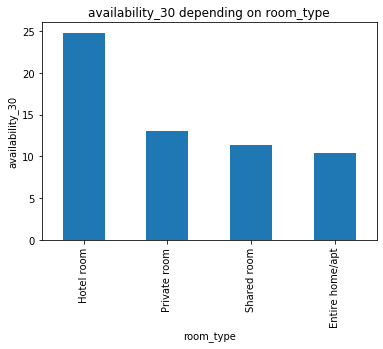

In [129]:
plot_bar(SantaM, 'room_type', 'availability_30')

It's very clear that hotel rooms are less popular than other room types (hotel rooms have twice as many available days in the next 30 days than other three types). Now let's see how the room types relate to the price of listings.

In [130]:
SantaM.groupby(['room_type'])['price'].mean().sort_values(ascending=False)

room_type
Hotel room         322.600000
Entire home/apt    204.181152
Private room       149.786231
Shared room        147.444444
Name: price, dtype: float64

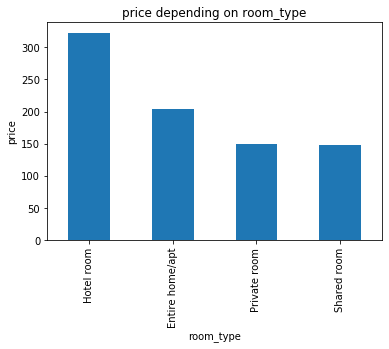

In [131]:
plot_bar(SantaM, 'room_type', 'price')

From the bar plot, it's clear that hotel rooms are very expensive, followed by entire home/apt, and private or shared rooms are least expansive. The reason why hotel rooms are less popular and have very low booking rates is likely due to its high listing price. But entire home/apt are still very popular despite the average price being high than 200 dollars per night. 

Now let's take a look at how bathroom types affect the availability and price of a listing. 

In [132]:
SantaM.bathrooms_text.value_counts().sort_values(ascending=False)

1 bath               583
2 baths              191
1 private bath       134
1 shared bath         82
1.5 baths             38
2.5 baths             21
3 baths               21
1.5 shared baths      19
4 baths                7
2 shared baths         5
4.5 baths              4
3.5 baths              3
5 baths                2
Shared half-bath       1
6 baths                1
2.5 shared baths       1
Private half-bath      1
Name: bathrooms_text, dtype: int64

The majority of listings in Santa Monica in Nov. 2020 are less than 3 baths. So these types will be the focus of following analysis. What does the availability of each bathroom type look like?

In [133]:
SantaM.groupby(['bathrooms_text'])['availability_30'].mean().sort_values(ascending=False)

bathrooms_text
6 baths              30.000000
Shared half-bath     29.000000
2.5 shared baths     23.000000
4.5 baths            20.250000
5 baths              19.000000
2 shared baths       18.000000
3.5 baths            17.666667
4 baths              16.428571
2.5 baths            15.904762
2 baths              14.664921
1 private bath       12.828358
1 shared bath        12.243902
3 baths              12.142857
1.5 baths            10.210526
1.5 shared baths      9.631579
1 bath                8.907376
Private half-bath     2.000000
Name: availability_30, dtype: float64

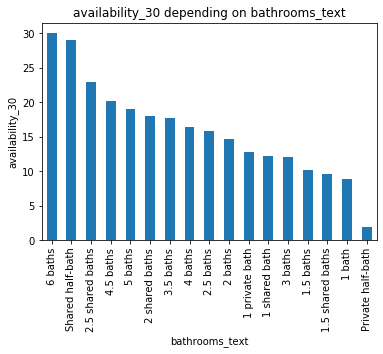

In [134]:
plot_bar(SantaM, 'bathrooms_text', 'availability_30')

In [135]:
SantaM.groupby(['bathrooms_text'])['price'].mean().sort_values(ascending=False)

bathrooms_text
4.5 baths            1843.750000
6 baths              1700.000000
4 baths              1117.142857
3.5 baths            1033.333333
5 baths               567.500000
3 baths               452.081429
2.5 baths             329.212857
2 baths               245.146597
1 private bath        181.850746
1.5 baths             165.710526
1 bath                150.336930
1 shared bath         104.353659
Shared half-bath      100.000000
2.5 shared baths       99.000000
Private half-bath      85.000000
2 shared baths         72.000000
1.5 shared baths       64.421053
Name: price, dtype: float64

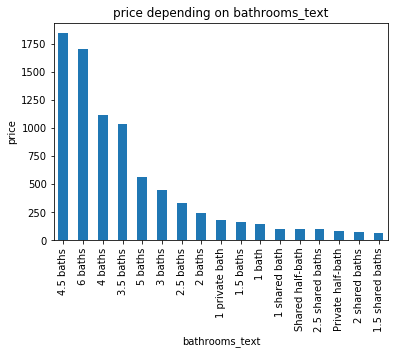

In [136]:
plot_bar(SantaM, 'bathrooms_text', 'price')

From these two plots, it's clear that although shared and private bathroom does not affect the availability very much, properties with private bathrooms have higher listing price on average than properties with shared bathrooms. This may be especially true durinng the pandemic (so one of my future practice will be to dig out archived data and see how much difference there is between private and shared bath before the pandemic).

### Question 2
Since it requires renovation (including HOA/city permit) to change the type of the room and bathroomm, let's take a look at whether addditional amenities will increase booking rate and price. What are the popular amenities offered by the hosts in Santa Monica? To answer this question, we need to first break the amenities text into individual amenity.

In [137]:
# break the amenities descriptions into individual amenity
amenities_list = list(SantaM.amenities)
amenities_list_string = " ".join(amenities_list)
amenities_list_string = amenities_list_string.replace('"', '')
amenities_list_string = amenities_list_string.replace('[', '')
amenities_list_string = amenities_list_string.replace(']', ',')
amenities_set = [x.strip() for x in amenities_list_string.split(',')] 

In [138]:
# count the frequency of individual amenity
temp = dict(Counter(amenities_set))
a_count = pd.DataFrame.from_dict(temp,orient='index',columns=['count'])
a_count.sort_values("count",ascending=False,inplace=True)

In [139]:
a_count.index

Index(['Wifi', 'Essentials', 'Smoke alarm', 'Heating', 'Hangers', 'TV',
       'Hair dryer', 'Kitchen', 'Iron', 'Carbon monoxide alarm',
       ...
       'Puracy conditioner', 'Puracy shampoo', 'Puracy body soap',
       'Puracy plant based and natural shampoo',
       'Puracy plant based and natural conditioner', '47\ HDTV with Netflix',
       'Puracy plant based and natural body soap',
       'Trader Joes shampoo/body wash combo body soap',
       'Trader Joes shampoo/body wash combo shampoo',
       'Free parking garage on premises'],
      dtype='object', length=162)

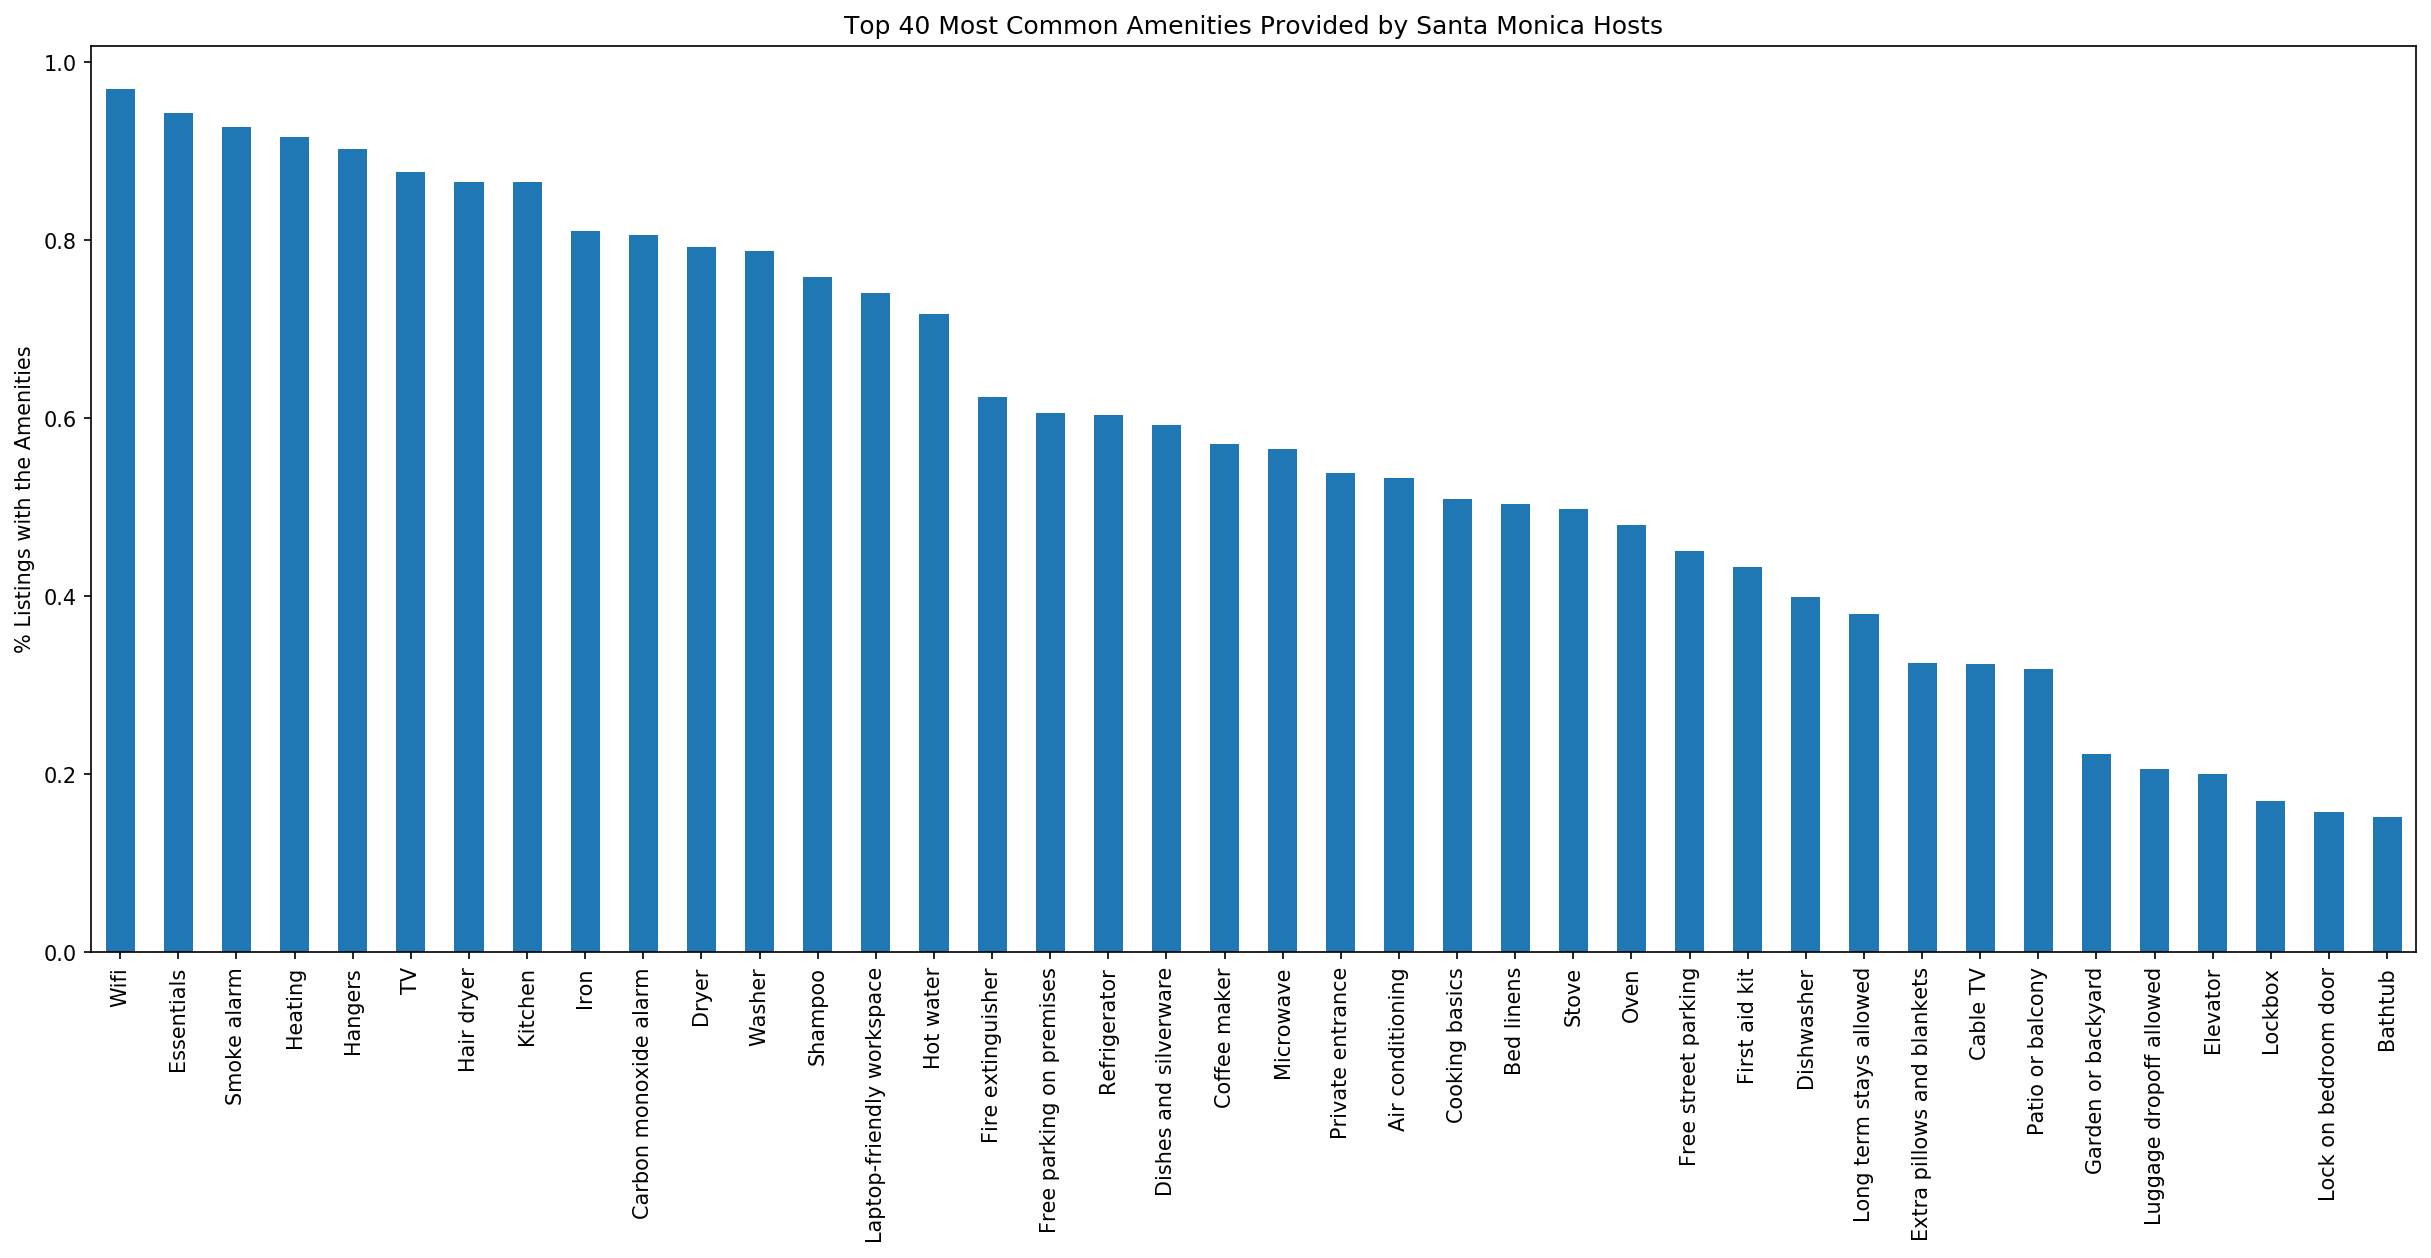

In [141]:
#Here I create a bar chart to show the percentage of each amenity from the most common to the least common.
top = 40
(a_count/len(SantaM))[:top].plot(kind='bar', legend=None);
plt.title('Top {} Most Common Amenities Provided by Santa Monica Hosts'.format(top));
plt.ylabel('% Listings with the Amenities')
plt.rcParams['figure.figsize'] = [16, 8]
plt.rcParams['figure.dpi'] = 150
plt.show()

In [142]:
(a_count/len(SantaM))[:1]

,count
Wifi,0.969507


From the plot, it's clear that more than 80% of the listings in Santa Monica are equipped with Wifi (96.9%), Essentials, Smoke alarm, Heating, Hangers, TV, and Kitchen. More than 60% of the listings are also equipped with Hair dryer, Iron, CO alarm, Dryer/Washer, Shampoo, Laptop-friendly workspace, and Hot water. 

### Question 3
What are the most influential features to estimate the price/availability of a listing?

To answer this question, we need to work with categorical variables in the "amenities" column. I will first create dummy variables for the top 40 amenities (found previously and stored in a_count dataframe). If the listing has a certain amenity, then the value will be "1" in that new column; if it does not, then the value will be "0".

In [164]:
top = 40
for i in range(top):
    SantaM[a_count.index[i]] = 0
for i in range(top):
    for t in range(len(SantaM)):
        if a_count.index[i] in SantaM.amenities[t]:
            SantaM.loc[t, a_count.index[i]] = 1
        else:
            SantaM.loc[t, a_count.index[i]] = 0

/Users/zhaoli/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/zhaoli/opt/anaconda3/lib/python3.7/site-packages/pandas/core/indexing.py:965: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [165]:
SantaM.shape

(1115, 112)

First let's take a look at the availability data. We want to find out the amenities that can increase the booking rate (i.e., have lower availability in the coming 30 days).

Here I define another function to create the comparison dataframe, so we can use it for other features later.

In [158]:
def amenities_importance(df, a_count, feature, top):
    
    """
    Create a comparison dataframe to see the importance of different amenities
    
    Parameters:
    df: Dataframe to be used
    a_count: Dataframe that stores the amenities name and frequency
    feature: the feature column that we focus on in this comparison, such as availability, price, etc.
    top: the top amenities in the a_count dataframe to be analysized in this comparison (because some amenities only appear once or a few times, so it's meanless to do a comparison)
    
    Returns:
    a dataframe that shows the average value of the listings with and without the feature of interest, and the difference between the two averages
    """
    
    df_temp = pd.DataFrame(index=range(0,top), columns=["Amenity_name", "Having", "Not_having", "Difference"])
    for i in range(top):
        df_temp['Amenity_name'][i] = a_count.index[i]
        df_temp['Having'][i] = df.groupby([a_count.index[i]])[feature].mean()[1]
        df_temp['Not_having'][i] = df.groupby([a_count.index[i]])[feature].mean()[0]
        df_temp['Difference'][i] = df_temp['Having'][i] - df_temp['Not_having'][i]
    return df_temp

In [166]:
a_availability = amenities_importance(SantaM, a_count, 'availability_30', top)
a_availability.sort_values('Difference')

,Amenity_name,Having,Not_having,Difference
0,Wifi,10.8504,19.2812,-8.43083
1,Essentials,10.7279,17.0781,-6.35025
4,Hangers,10.7396,14.3486,-3.60906
8,Iron,10.6113,13.1415,-2.53021
6,Hair dryer,10.7813,13.0933,-2.31199
24,Bed linens,9.96619,12.2369,-2.2707
17,Refrigerator,10.2838,12.3235,-2.03973
12,Shampoo,10.6057,12.6306,-2.02493
19,Coffee maker,10.2449,12.2218,-1.97686
18,Dishes and silverware,10.3041,12.2401,-1.936


It's clear that Wifi, Essentials, Hangers, Iron, Hair dryer, Bed linens, Refrigerator, and Shampoo are the amenities that help increase the booking rate. Now let's take a look at whether they also help increase the price of the listing.

In [169]:
a_price = amenities_importance(SantaM, a_count, 'price', top)
a_price.sort_values('Difference', ascending=False) # because we want to find out the amenities that increase the price, the result will be descending based on the values in the "Difference" column

,Amenity_name,Having,Not_having,Difference
22,Air conditioning,225.699,151.825,73.8742
36,Elevator,240.335,178.891,61.4439
9,Carbon monoxide alarm,201.297,149.072,52.225
16,Free parking on premises,206.952,166.984,39.9679
5,TV,195.372,159.962,35.4098
2,Smoke alarm,193.506,161.489,32.0173
39,Bathtub,212.537,187.365,25.1725
28,First aid kit,204.41,181.069,23.3416
32,Cable TV,204.333,184.882,19.4508
10,Dryer,193.456,181.813,11.6431


It's interesting to see that in term of price, the most "helpful" amenities are AC, Elevator, CO alarm, Free parking on premises, TV, Smoke alarm, Bathtub, and First aid kit. None of the previously found "helpful" features for booking rate appears here. Based on my own observation, many travelers who come to Santa Monica are for short-term study and working (internship), so more basic amenities (such as Wifi, Essentials, Hangers and Refrigerator) help them settle down in this area at lower cost, while more upgraded amenities (such as AC, Elevator and Bathtub) do not help a listing become more popular likely because they increase the price. The results I found in answering Question 3 seem to support my observations. 

## Evaluation

Here are my findings when I seek the answers to the above three questions:  
(1) "Entire home/apt" is the most popular room type in Santa Monica in Nov. 2020, these listings have high booking rate despite their relatively high prices.  
(2) "Shared bathrooms" do not make the listing less popular, but they decrease the average listing price.  
(3) More than 80% of Santa Monica listings provide Wifi, Essentials, Smoke alarm, Heating, Hanger, TV, Hair dryer, and Kitchen, so it's very convenient for travelers to stay in Santa Monica Airbnbs for working-from-home and cooking.  
(4) To increase the booking rate, a host in Santa Monica can add more basic amenities (for example, we are considering to buy an iron for our guests), and to increase the price, a host can invest on more upgraded amenities.